In [1]:
from nilearn import image
import nilearn
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn import plotting
import argparse
import sys 
from os import path

%matplotlib inline

In [2]:
BIDS_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans'

fmriprep_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/fmriprep'
secondlvl_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/'

task_dirs = [i for i in glob(path.join(secondlvl_dir, '*')) if '.' not in i]

In [8]:
ls /oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/*/secondlevel-RT-False_beta-False_maps/

/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/ANT/secondlevel-RT-False_beta-False_maps/:
ANT_corrected_tfile_plots.pdf         contrast-task.nii.gz
ANT_plots.pdf                         contrast-task_raw_tfile.nii.gz
ANT_raw_tfile_plots.pdf               metadata.txt
contrast-task_corrected_tfile.nii.gz

/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/CCTHot/secondlevel-RT-False_beta-False_maps/:
CCTHot_corrected_tfile_plots.pdf      contrast-task.nii.gz
CCTHot_plots.pdf                      contrast-task_raw_tfile.nii.gz
CCTHot_raw_tfile_plots.pdf            metadata.txt
contrast-task_corrected_tfile.nii.gz

/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/discountFix/secondlevel-RT-False_beta-False_maps/:
contrast-task_corrected_tfile.nii.gz   discountFix_plots.pdf
contrast-task.nii.gz                   discountFix_raw_tfile_plots.pdf
contrast-task_raw_tfile.nii.gz         metadata.txt
discountFix_co

# __ get task z_score per network (yeo et al 2011, 17network)__

In [75]:
yeo = datasets.fetch_atlas_yeo_2011()

masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=False,
                           memory='nilearn_cache')

parcel_z_scores = {
    'True': {},
    'False': {},
}
for task_dir in task_dirs:
    curr_task = task_dir.split('/')[-1]
    rt_dirs = glob(path.join(task_dir, '*'))
    for rt_dir in rt_dirs:
        rt_flag = rt_dir.split('RT-')[-1].split('_')[0]
        try:
            parcs = masker.fit_transform([path.join(rt_dir, 'contrast-task.nii.gz')])
        except ValueError:
            parcs = masker.fit_transform([path.join(rt_dir, 'contrast-trial.nii.gz')]) #for WATT3
        parcel_z_scores[rt_flag][curr_task] = parcs[0]

In [3]:
label_dict = {1.0: ['central visual', 'central visual', 'central visual', 'central visual'],
 2.0: ['peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual'],
 3.0: ['somatomotor A', 'somatomotor A'],
 4.0: ['somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B'],
 5.0: ['dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A'],
 6.0: ['dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B'],
 7.0: ['salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A'],
 8.0: ['salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B'],
 9.0: ['limbic A', 'limbic A'],
 10.0: ['limbic B', 'limbic B'],
 12.0: ['control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A'],
 13.0: ['control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B'],
 11.0: ['control C', 'control C', 'control C', 'control C'],
 16.0: ['default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A'],
 17.0: ['default B',
  'default B',
  'default B',
  'default B',
  'default B',
  'default B',
  'default B'],
 15.0: ['default C',
  'default C',
  'default C',
  'default C',
  'default C',
  'default C'],
 14.0: ['temporal parietal', 'temporal parietal']}

In [159]:
RT_False_Zs = pd.DataFrame(parcel_z_scores['False'])
labels = [label_dict[i+1][0] for i in RT_False_Zs.index]
RT_False_Zs.index=labels
RT_False_Zs.index.name= 'Yeo (2011) label'

In [160]:
RT_False_Zs

,WATT3,stroop,motorSelectiveStop,ANT,CCTHot,DPX,stopSignal,discountFix,twoByTwo
Yeo (2011) label,,,,,,,,,
central visual,5.806685,1.006061,-1.748508,0.923843,5.362676,-2.083304,-0.427636,-0.923817,1.730060
peripheral visual,-3.330717,-5.110117,-5.652045,-5.221199,1.493976,-4.688476,-7.014065,-4.508472,-4.160211
somatomotor A,0.010281,0.997845,-3.610731,-0.759037,-1.821677,0.579204,-2.814445,-0.804985,1.486717
somatomotor B,-1.795560,-1.054555,-3.837285,-2.380636,-3.234256,0.801694,-2.940501,-0.225654,0.125126
dorsal attention A,6.893321,1.230603,0.075625,2.615326,3.568801,0.732072,0.956608,-1.188031,2.312308
dorsal attention B,8.741958,1.677650,-0.122262,0.775707,1.937741,0.495297,0.053403,-1.157620,0.518334
salience / ventral attention A,3.315912,-0.626514,-1.446289,-2.971908,1.559476,-1.607770,-0.675430,-0.195987,-2.061887
salience / ventral attention B,1.306232,-1.644096,1.781622,-3.185211,3.759497,-2.640741,1.812026,1.437007,-3.796943
limbic A,-3.509119,-0.878114,-1.873081,-0.366067,0.744069,-0.619009,-1.008082,-0.379606,-1.542028


In [161]:
RT_False_Zs.to_csv('uh2Aim1_yeoNetworks_Zscores_RT-False.csv')

In [162]:
RT_True_Zs = pd.DataFrame(parcel_z_scores['True'])
labels = [label_dict[i+1][0] for i in RT_True_Zs.index]
RT_True_Zs.index=labels
RT_True_Zs.index.name= 'Yeo (2011) label'

In [163]:
RT_True_Zs

,WATT3,stroop,motorSelectiveStop,ANT,CCTHot,DPX,stopSignal,discountFix,twoByTwo
Yeo (2011) label,,,,,,,,,
central visual,6.524273,0.990107,-1.748508,0.900778,5.602875,-2.112462,-0.427636,-1.004183,1.658724
peripheral visual,-2.258727,-5.071477,-5.652045,-5.191863,1.817348,-4.698258,-7.014065,-4.522433,-4.156578
somatomotor A,-1.924871,1.116850,-3.610731,-0.651991,-1.748550,0.530619,-2.814445,-0.788478,1.496223
somatomotor B,-3.824904,-1.069904,-3.837285,-2.338500,-3.182126,0.786544,-2.940501,-0.220258,0.051231
dorsal attention A,6.721385,1.310431,0.075625,2.613359,3.793457,0.621218,0.956608,-1.308738,2.391209
dorsal attention B,7.637013,1.906446,-0.122262,0.834360,2.010866,0.391689,0.053403,-1.256171,0.693776
salience / ventral attention A,0.994542,-0.353725,-1.446289,-2.886409,1.555726,-1.637495,-0.675430,-0.235094,-1.892781
salience / ventral attention B,0.530800,-1.373647,1.781622,-3.148236,3.532636,-2.668114,1.812026,1.285469,-3.541817
limbic A,-3.037454,-0.778331,-1.873081,-0.329308,0.749120,-0.629349,-1.008082,-0.418991,-1.522730


In [164]:
RT_True_Zs.to_csv('uh2Aim1_yeoNetworks_Zscores_RT-True.csv')

# __Getting task-locked BOLD timeseries__

In [4]:
from nideconv.utils.roi import get_fmriprep_timeseries
from bids import BIDSLayout
import pandas as pd
from nilearn import input_data
import nibabel as nb
from nilearn._utils import check_niimg
from nilearn import image
import numpy as np


In [8]:
sourcedata_layout = BIDSLayout(BIDS_dir)

In [9]:
def _make_psc(data):
    mean_img = image.mean_img(data)

    # Replace 0s for numerical reasons
    mean_data = mean_img.get_data()
    mean_data[mean_data == 0] = 1
    denom = image.new_img_like(mean_img, mean_data)

    return image.math_img('data / denom[..., np.newaxis] * 100 - 100',
                          data=data, denom=denom)

def extract_timecourse_from_nii(atlas,
                                nii,
                                mask=None,
                                confounds=None,
                                atlas_type=None,
                                t_r=None,
                                low_pass=None,
                                high_pass=1./128,
                                *args,
                                **kwargs):
    """
    Extract time courses from a 4D `nii`, one for each label 
    or map in `atlas`,
    This method extracts a set of time series from a 4D nifti file
    (usually BOLD fMRI), corresponding to the ROIs in `atlas`.
    It also performs some minimal preprocessing using 
    `nilearn.signal.clean`.
    It is especially convenient when using atlases from the
    `nilearn.datasets`-module.
    Parameters
    ----------
    atlas: sklearn.datasets.base.Bunch  
        This Bunch should contain at least a `maps`-attribute
        containing a label (3D) or probabilistic atlas (4D),
        as well as an `label` attribute, with one label for
        every ROI in the atlas.
        The function automatically detects which of the two is
        provided. It extracts a (weighted) time course per ROI.
        In the case of the probabilistic atlas, the voxels are
        weighted by their probability (see also the Mappers in
        nilearn).
    nii: 4D niimg-like object
        This NiftiImage contains the time series that need to
        be extracted using `atlas`
    mask: 3D niimg-like object
        Before time series are extracted, this mask is applied,
        can be useful if you want to exclude non-gray matter.
    confounds: CSV file or array-like, optional
        This parameter is passed to nilearn.signal.clean. Please 
        see the related documentation for details.
        shape: (number of scans, number of confounds)
    atlas_type: str, optional
        Can be 'labels' or 'probabilistic'. A label atlas
        should be 3D and contains one unique number per ROI.
        A Probabilistic atlas contains as many volume as 
        ROIs.
        Usually, `atlas_type` can be detected automatically.
    t_r, float, optional
        Repetition time of `nii`. Can be important for
        temporal filtering.
    low_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    high_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    Examples
    --------
    >>> from nilearn import datasets
    >>> data = '/data/ds001/derivatives/fmriprep/sub-01/func/sub-01_task-checkerboard_bold.nii.gz'
    >>> atlas = datasets.fetch_atlas_pauli_2017()
    >>> ts = extract_timecourse_from_nii(atlas,
                                         data,
                                         t_r=1.5)
    >>> ts.head()
    """

    standardize = kwargs.pop('standardize', False)
    detrend = kwargs.pop('detrend', False)

    if atlas_type is None:
        maps = check_niimg(atlas.maps)

        if len(maps.shape) == 3:
            atlas_type = 'labels'
        else:
            atlas_type = 'prob'

    if atlas_type == 'labels':
        masker = input_data.NiftiLabelsMasker(atlas,
                                              mask_img=mask,
                                              standardize=standardize,
                                              detrend=detrend,
                                              t_r=t_r,
                                              low_pass=low_pass,
                                              high_pass=high_pass,
                                              *args, **kwargs)
    else:
        masker = input_data.NiftiMapsMasker(atlas.maps,
                                            mask_img=mask,
                                            standardize=standardize,
                                            detrend=detrend,
                                            t_r=t_r,
                                            low_pass=low_pass,
                                            high_pass=high_pass,
                                            *args, **kwargs)

    data = _make_psc(nii)

    results = masker.fit_transform(data,
                                   confounds=confounds)

#     # For weird atlases that have a label for the background
#     if len(atlas.labels) == results.shape[1] + 1:
#         atlas.labels = atlas.labels[1:]

    if t_r is None:
        t_r = 1

    index = pd.Index(np.arange(0,
                               t_r*data.shape[-1],
                               t_r),
                     name='time')

#     columns = pd.Index(atlas.labels,
#                        name='roi')

    return pd.DataFrame(results,
                        index=index,
                        )

def get_onsets(events, task_conditions=['Task'], scanner_times=None):
    onsets = events.loc[events.condition.isin(task_conditions), 'onset'].values
    #round to nearest scanner time if available
    if scanner_times is not None: 
#         onsets = [min(scanner_times, key=lambda x:abs(x-i)) for i in onsets] #takes closest value
        onsets = [scanner_times[scanner_times > i].min() for i in onsets] #takes closest _larger_ value
        
    return(onsets)

In [11]:
yeo = datasets.fetch_atlas_yeo_2011()

deriv_base_path = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-*/ses-*/func/'
source_path = path.join(BIDS_dir, 'sub-*/ses-*/func/*%s*bold.nii.gz') #for oringal filepaths for metadata
prep_path = path.join(deriv_base_path, '*%s*space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz') #for mnispace preprocessed
evs_path = path.join(BIDS_dir, 'sub-*/ses-*/func/*%s*events.tsv') #for timelocking
dsgn_path = path.join(BIDS_dir, 'derivatives/1stlevel/s*/%s/design_RT-False_beta-False.csv') #for confounds

task_sources = glob(source_path % 'DPX')
task_funcs = glob(prep_path % 'DPX')
task_evs = glob(evs_path % 'DPX')
task_dsgns = glob(dsgn_path % 'DPX')


task_funcs.sort()
task_dsgns.sort()
task_sources.sort()
task_evs.sort()

print('num raw funcs', len(task_sources))
print('num mni funcs', len(task_funcs))
print('num ev files', len(task_evs))
print('num dsgn files', len(task_dsgns))

num raw funcs 104
num mni funcs 101
num ev files 103
num dsgn files 100


In [12]:
confounds_to_include = ['framewise_displacement', 'a_comp_cor_00',
                        'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
                        'a_comp_cor_04', 'a_comp_cor_05', 'a_comp_cor_06',
                        'a_comp_cor_07', 'trans_x', 'trans_y', 'trans_z',
                        'rot_x', 'rot_y', 'rot_z']

num_nets = 17
num_trs = 15 #to average over


subject_network_responses = np.empty((num_trs, num_nets, len(task_funcs)))
subject_network_responses[:] = np.nan
for idx, func in enumerate(task_funcs[:2]):
    
    #set up nan array 
    meaned_responses = np.empty((num_trs,num_nets))
    meaned_responses[:] = np.nan
    
    #make sure sub has all required files
    sub_str = func.split('sub-')[1].split('/')[0]
    print(sub_str)
    #get relavent sub strs
    sub_dsgn = [i for i in task_dsgns if sub_str in i]
    sub_source = [i for i in task_sources if sub_str in i]
    sub_evs = [i for i in task_evs if sub_str in i]
    
    #if they are missing a file, skip them
    if (len(sub_dsgn)==0) | (len(sub_source)==0) | (len(sub_evs)==0):
        print('missing something for sub'+sub_str)
        subject_network_responses[:,:,idx] = meaned_responses
        continue
    sub_dsgn = sub_dsgn[0]
    sub_source = sub_source[0]
    sub_evs = sub_evs[0]
    
    meta = sourcedata_layout.get_metadata(sub_source)
    confounds= pd.read_csv(sub_dsgn) 
    evs = pd.read_csv(sub_evs, delimiter='\t')

    TR = meta['RepetitionTime']



    #extract timeseries for 
    tc = extract_timecourse_from_nii(yeo['thick_17'],
                                     func, #testing on the first funcional run
                                     t_r=TR,
                                     atlas_type='labels',
                                     low_pass=None,
                                     high_pass=1./128,
                                     confounds=confounds[confounds_to_include].values)

    # get task onsets, shift to the nearest (larger) TR
    onsets = get_onsets(evs, task_conditions=['AX', 'AY', 'BX', 'BY'], scanner_times=tc.index)

    # take num_trs of signal for each network at each task onset
    timelocked_data = np.zeros((num_trs, num_nets, len(onsets)))
    for jdx, onset in enumerate(onsets):
        curr_resp = tc.loc[onset:onset+(num_trs*TR), :].head(num_trs).values
        timelocked_data[:,:, jdx] = curr_resp
        
    # mean across onsets
    meaned_responses = np.mean(timelocked_data, axis=2)
    
    #append subj means to get group
    subject_network_responses[:,:,idx] = meaned_responses

s061
s130


In [21]:
group_resps = np.nanmean(subject_network_responses, axis=2)

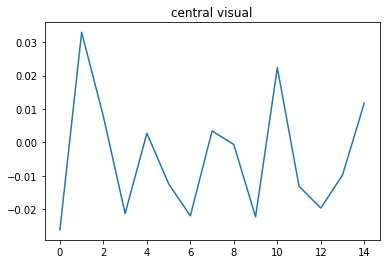

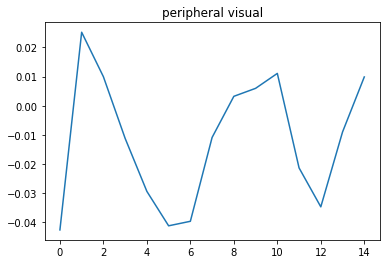

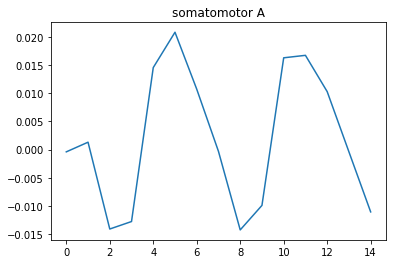

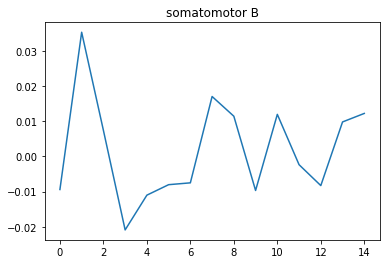

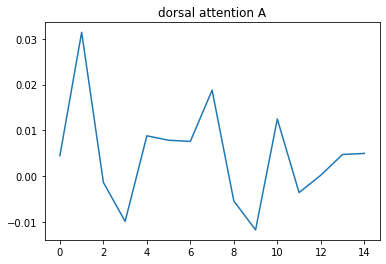

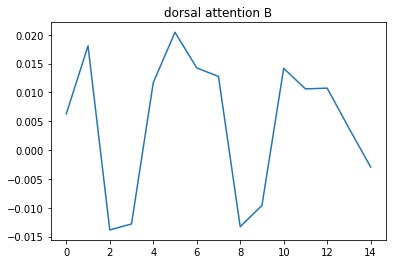

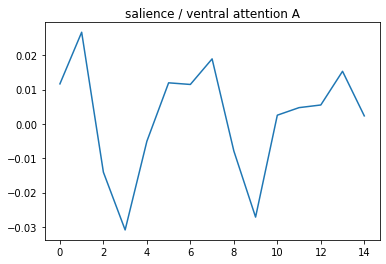

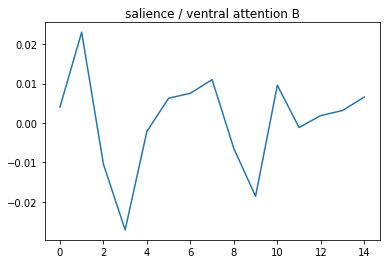

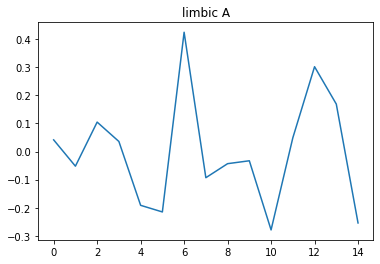

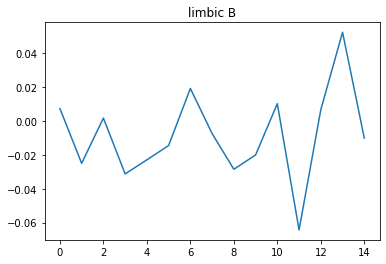

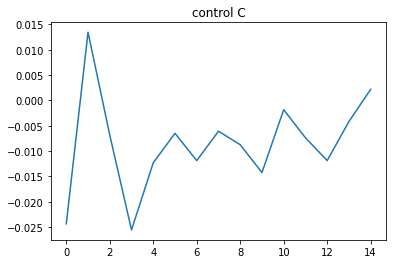

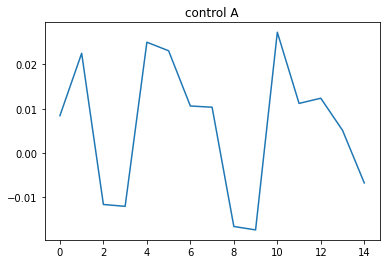

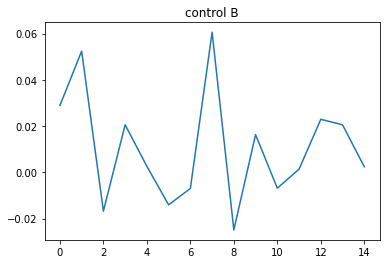

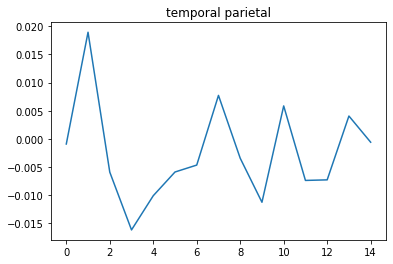

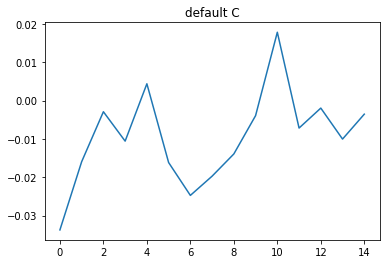

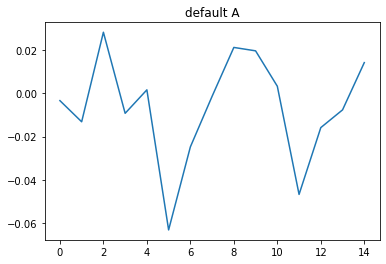

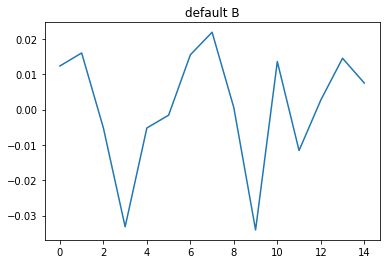

In [22]:
for network in range(group_resps.shape[1]):
    plt.plot(group_resps[:,network], )
    plt.title(label_dict[network+1][0])
    plt.show()
    plt.close()
# leg = []
# for network in range(practive_resps.shape[1]):
#     plt.plot(practive_resps[:,network])
#     leg.append(label_dict[network+1][0])
#     plt.legend(leg)

In [147]:
meaned_responses.shape[1]

17

In [134]:
timelocked_data[:,:, 0]

array([[-4.45079297e-01, -9.58751023e-01, -2.02819809e-01,
        -4.03311372e-01, -2.23080501e-01, -1.79012701e-01,
        -2.31335104e-01, -3.09382647e-01, -1.13193636e+01,
        -3.14818919e-01, -7.40599811e-01, -3.28080893e-01,
        -8.41316521e-01, -1.36237413e-01, -6.80315614e-01,
        -6.11951947e-01, -1.78494066e-01],
       [-2.85540104e-01, -8.77947211e-01, -9.45054144e-02,
        -2.48546138e-01, -9.49012935e-02, -9.92011577e-02,
        -4.61284667e-02, -2.27004573e-01, -4.24469519e+00,
        -2.57090420e-01, -5.24646640e-01, -2.36276805e-01,
         3.44099551e-01, -8.12401250e-02, -4.74405110e-01,
        -3.49777520e-01, -2.77416766e-01],
       [-1.52273431e-01, -8.75448406e-01, -8.58576000e-02,
        -3.14028710e-01, -9.93112288e-03, -7.14241490e-02,
        -3.80330011e-02, -1.29117131e-01,  9.32045162e-01,
         1.21416695e-01, -4.66725767e-01, -1.13263197e-01,
        -4.46678907e-01, -1.27748385e-01, -5.08790374e-01,
        -5.81713989e-02, -1.5